# Vietnamese News Classification

#GPU Information

In [ ]:
!nvidia-smi

Sat Sep 18 14:52:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import Libs

In [ ]:
import numpy as np
import random
import os
import time
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.spatial.distance import cosine as cosine_dist
from sklearn.metrics import confusion_matrix, classification_report
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

#Introduction

Ở phần trước thì em đã sử dụng các thuật toán Machine Learning để giải quyết bài toán. Ở phần này, em sẽ cố gắng giải quyết bài toán những phương pháp phức tạp hơn với mong muốn làm cho mô hình hiệu quả hơn.

Nhìn chung, mô hình được chia làm 3 phần:

  1. Tiền xử lý dữ liệu
  2. Trích chọn đặc trưng
  3. Phân loại

Quan sát 3 bước trên, bước tiền xử lý dữ liệu có thể gọi là ổn và khó có thể tăng được độ chính xác ở bước đó. Bước phân loại sử dụng mô hình SVM đã là khá tốt để phân loại trong hầu hết trường hợp, để có thể có được một mô hình mạng neuron phân loại tốt hơn thì mạng đó phải tương đối nhiều layers và mỗi layers phải có khá nhiều nút và đặc biệt, độ chính xác của việc phân loại sẽ bị ảnh hưởng trực tiếp bởi độ tốt của features đã trích xuất được ở bước 2, do đó, có thể nói 'cổ chai' của hệ thống không nằm ở bước 1 và bước 3 mà tập trung chủ yếu ở bước 2.

Trong bước 2, ở phần trước thì em đã sử dụng phương pháp TF-IDF để trích chọn đặc trưng ra được một kết quả khá tốt, tuy nhiên phương pháp này lại bỏ qua một đặc điểm quan trọng của văn bản đó là tính tuần tự trước sau, ngữ cảnh hay cảm xúc. Do đó, chúng ta sẽ cố gắng xây dựng một mô hình feature extractor mới sao cho có thể tận dụng được đặc điểm này của văn bản. Do đó, phần này, em sẽ tập trung chủ yếu vào việc tìm một bộ trích chọn đặc trưng văn bản đủ tốt cho mô hình.

Và một trong số những phương pháp Sentence Embedding phổ biến nhất hiện nay là Doc2Vec, một phiên bản mở rộng của Word2Vec.

#Load data

In [ ]:
# Đường dẫn
train_x_path = '/content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/train_x.sav'
train_y_path = '/content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/train_y.sav'
test_x_path = '/content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/test_x.sav'
test_y_path = '/content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/test_y.sav'

In [ ]:
# load data
train_x = pickle.load(open(train_x_path, 'rb'))
train_y = pickle.load(open(train_y_path, 'rb'))
test_x = pickle.load(open(test_x_path, 'rb'))
test_y = pickle.load(open(test_y_path, 'rb'))

In [ ]:
# load labels
labels = os.listdir('/content/drive/MyDrive/The Anh Tran/Final Coursework/Data/Train')
print('Number of labels: ', len(labels))
labels = sorted(labels)
labels

Number of labels:  27


['Am nhac',
 'Am thuc',
 'Bat dong san',
 'Bong da',
 'Chung khoan',
 'Cum ga',
 'Cuoc song do day',
 'Du hoc',
 'Du lich',
 'Duong vao WTO',
 'Gia dinh',
 'Giai tri tin hoc',
 'Giao duc',
 'Gioi tinh',
 'Hackers va Virus',
 'Hinh su',
 'Khong gian song',
 'Kinh doanh quoc te',
 'Lam dep',
 'Loi song',
 'Mua sam',
 'My thuat',
 'San khau dien anh',
 'San pham tin hoc moi',
 'Tennis',
 'The gioi tre',
 'Thoi trang']

#Doc2Vec

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

##1. Preprocessing data

In [ ]:
# Chuyển sentence về dạng list token
# train set
print('Processing train set ...')
for i, x in enumerate(tqdm(train_x)):
  train_x[i] = list(x.split(' '))

print('Processing test set ...')
for i, x in enumerate(tqdm(test_x)):
  test_x[i] = list(x.split(' '))

Processing train set ...


  0%|          | 0/14375 [00:00<?, ?it/s]

Processing test set ...


  0%|          | 0/12076 [00:00<?, ?it/s]

In [ ]:
print(train_x[0])

['mỗi', 'đạo_diễn', 'dựng', 'vở', 'hội_diễn', 'thông_báo', 'cục', 'nghệ_thuật', 'biểu_diễn', 'vh', 'tt', 'quy_định', 'hội_diễn', 'sân_khấu', 'đạo_diễn', 'dựng', 'quá', 'vở', 'dư_luận', 'xôn_xao', 'cục_trưởng', 'lê_ngọc_cường', 'ý_kiến', 'vấn_đề', 'văn_bản', 'thực_thi', 'thế_nào', 'thưa', 'chúng_tôi', 'thảo', 'thông_báo', 'gửi', 'đơn_vị', 'nghệ_thuật', 'tham_gia', 'hội_diễn', '2005', 'tuồng', 'cải_lương', 'dịp', '304', 'chèo', '10', 'hội_diễn', 'ca_múa_nhạc', 'đối_với', 'phía', 'bắc', '10', 'đối_với', 'phía', 'cục', 'soạn_thảo', 'quy_chế', 'bối_cảnh', 'đoàn', 'đều', 'cơ_chế_thị_trường', 'sân_khấu', 'kêu_gọi', 'xã_hội_hóa', 'hạn_chế', 'đạo_diễn', 'như_thế', 'chơi', 'khó', 'đoàn', 'nghĩ', 'sao', 'chính', 'xã_hội_hóa', 'hoạt_động', 'sân_khấu', 'càng', 'cần', 'tạo', 'điều_kiện', 'đạo_diễn', 'tham_gia', 'lớp', 'trẻ', 'tham_gia', 'gây', 'trống_trải', 'thế_hệ', 'dư_luận', 'kêu_ca', 'chất_lượng', 'sân_khấu', 'nâng', 'đạo_diễn', 'gạo_cội', 'lối', 'mòn', 'giải_pháp', 'hoạt_động', 'sân_khấu', 'tốt

In [ ]:
# add tag vào từng doc
tag_data = [TaggedDocument(doc, [i]) for i, doc in enumerate(train_x)]
tag_data[:5]

[TaggedDocument(words=['mỗi', 'đạo_diễn', 'dựng', 'vở', 'hội_diễn', 'thông_báo', 'cục', 'nghệ_thuật', 'biểu_diễn', 'vh', 'tt', 'quy_định', 'hội_diễn', 'sân_khấu', 'đạo_diễn', 'dựng', 'quá', 'vở', 'dư_luận', 'xôn_xao', 'cục_trưởng', 'lê_ngọc_cường', 'ý_kiến', 'vấn_đề', 'văn_bản', 'thực_thi', 'thế_nào', 'thưa', 'chúng_tôi', 'thảo', 'thông_báo', 'gửi', 'đơn_vị', 'nghệ_thuật', 'tham_gia', 'hội_diễn', '2005', 'tuồng', 'cải_lương', 'dịp', '304', 'chèo', '10', 'hội_diễn', 'ca_múa_nhạc', 'đối_với', 'phía', 'bắc', '10', 'đối_với', 'phía', 'cục', 'soạn_thảo', 'quy_chế', 'bối_cảnh', 'đoàn', 'đều', 'cơ_chế_thị_trường', 'sân_khấu', 'kêu_gọi', 'xã_hội_hóa', 'hạn_chế', 'đạo_diễn', 'như_thế', 'chơi', 'khó', 'đoàn', 'nghĩ', 'sao', 'chính', 'xã_hội_hóa', 'hoạt_động', 'sân_khấu', 'càng', 'cần', 'tạo', 'điều_kiện', 'đạo_diễn', 'tham_gia', 'lớp', 'trẻ', 'tham_gia', 'gây', 'trống_trải', 'thế_hệ', 'dư_luận', 'kêu_ca', 'chất_lượng', 'sân_khấu', 'nâng', 'đạo_diễn', 'gạo_cội', 'lối', 'mòn', 'giải_pháp', 'hoạt_đ

##2. Train Doc2Vec model

In [ ]:
# Train doc2vec model
# tag_data là list TaggedDocument
# vector_size là kích thước vector sẽ được embed ra của văn bản
# window là kích thước cửa sổ
# alpha là learning rate
# min_alpha là learning rate thấp nhất do mô hình sẽ giảm lr trong quá trình train
# workers là số luồng sử dụng để train
# min_count là số từ tối thiểu để được thêm vào vocab
# epochs là số epochs
start = time.time()
model = Doc2Vec(tag_data, vector_size=256, window=3, alpha=0.001, min_alpha=1e-6, workers=4, min_count=2, epochs=100)

print('Model Doc2Vec finish training after %d seconds' %(time.time() - start))

doc2vec_path = '/content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/Doc2Vec.model'
model.save(doc2vec_path)
print('Model saved to %s' %(doc2vec_path))

# In vocab
print('Vocab size: ', len(model.wv.vocab))

Model Doc2Vec finish training after 971 seconds
Model saved to /content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/Doc2Vec.model
Vocab size:  47671


##3. Đánh giá hiệu quả phân cụm của mô hình

In [ ]:
# lấy các vector embedding từ tập train
doc2vec_path = '/content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/Doc2Vec.model'
model = Doc2Vec.load(doc2vec_path)
embedded_vector = []

for x in range(len(train_x)):
  embedded_vector.append(model.docvecs[x])

print('Dataset size: ', len(embedded_vector))

Dataset size:  14375


In [ ]:
# Visualize 2D
# Chuyển vector sang 2D
tsne = TSNE(n_components=2, random_state=0)
x_2d = tsne.fit_transform(embedded_vector)

print('Embedded shape: ', x_2d.shape)

Embedded shape:  (14375, 2)


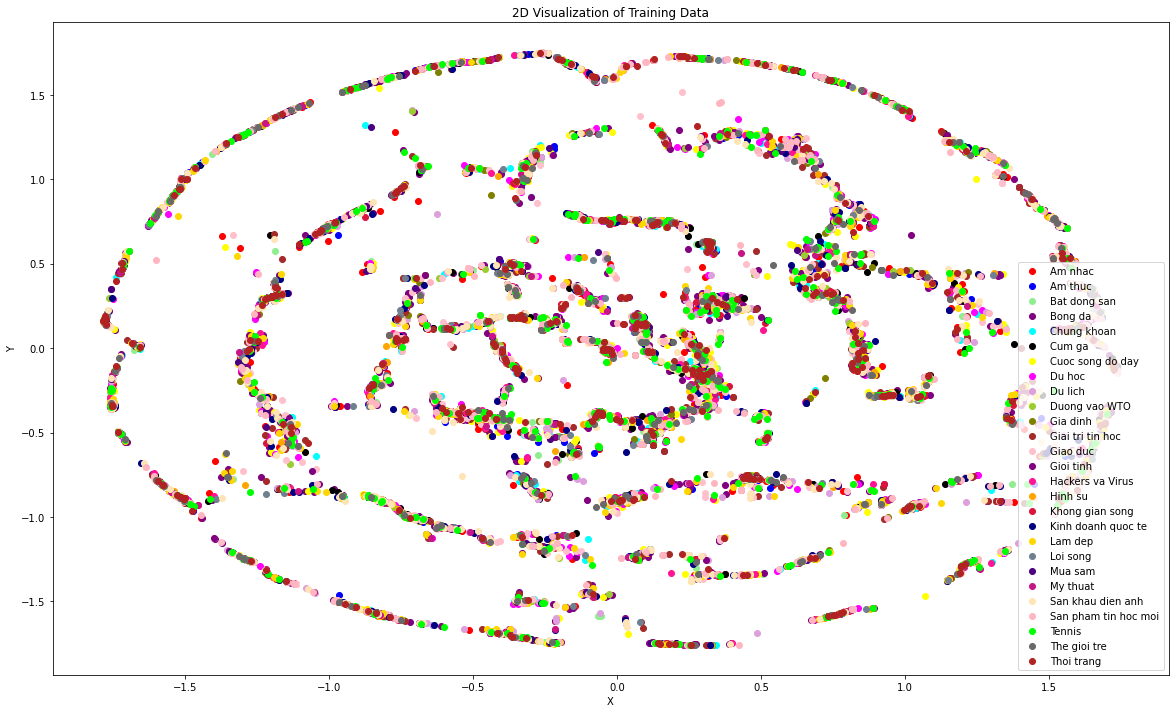

In [ ]:
# visualize
plt.figure(figsize=(20, 12))
color_map = {
    0: 'red', 1: 'blue', 2: 'lightgreen', 3: 'purple', 4: 'cyan', 5: 'black', 6: 'yellow', 7: 'magenta',
    8: 'plum', 9: 'yellowgreen', 10: 'olive', 11: 'brown', 12: 'pink', 13: 'purple', 14: 'deeppink', 
    15: 'orange', 16: 'crimson', 17: 'navy', 18: 'gold', 19: 'greenyellow', 19: 'aquamarine', 19: 'slategrey',
    20: 'indigo', 21: 'mediumvioletred', 22: 'moccasin', 23: 'lightpink', 24: 'lime', 25: 'dimgrey', 26: 'firebrick'
}

train_y = np.array(train_y)

for idx, label in enumerate(labels):
  plt.scatter(x=x_2d[train_y == label, 0], y=x_2d[train_y == label, 1], c=color_map[idx], marker='o', label=label)

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('2D Visualization of Training Data')
plt.show()

Có vẻ như 2D là chưa đủ để biểu diễn, ta sẽ thử với 3D.

In [ ]:
# Visulize 3D
tsne = TSNE(n_components=3, random_state=0)
x_3d = tsne.fit_transform(embedded_vector)

print('Embedded shape: ', x_3d.shape)

Embedded shape:  (14375, 3)


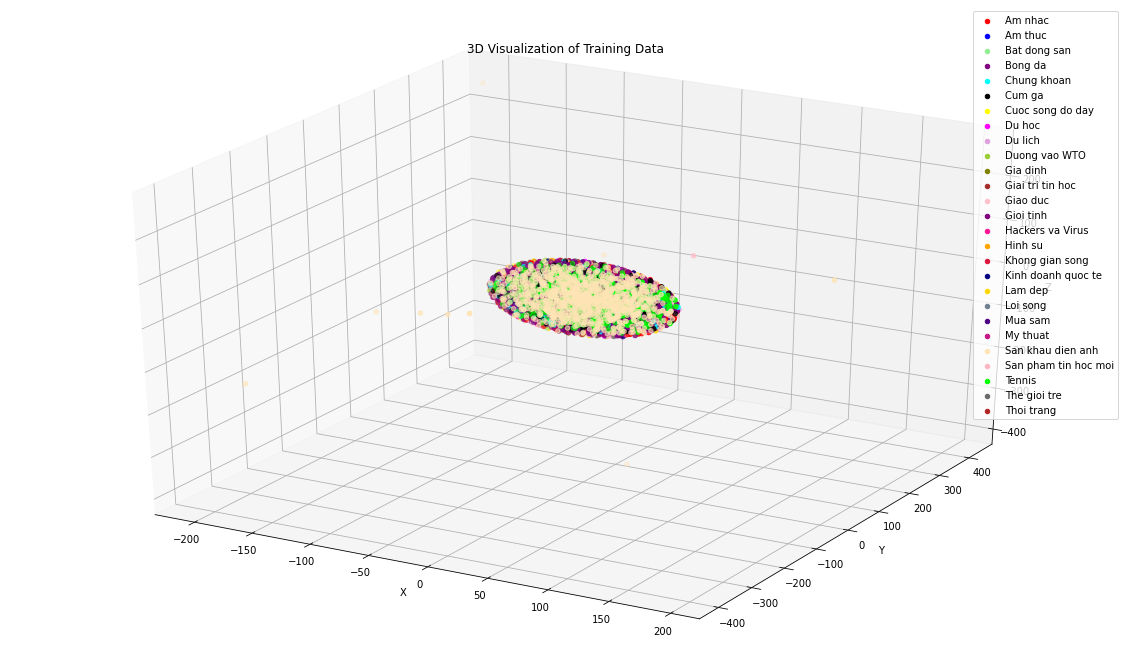

In [ ]:
ax = plt.figure(figsize=(20,12)).gca(projection='3d')

for idx, label in enumerate(labels):
  ax.scatter(x_3d[train_y == label, 0], x_3d[train_y == label, 1], x_3d[train_y == label, 2], c=color_map[idx], marker='o', label=label)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.title('3D Visualization of Training Data')
plt.show()

**Nhận xét:** Dù hiển thị dưới dạng 3D nhưng vẫn không thể quan sát được sự phân cụm của các bộ dữ liệu. Vì vậy, có thể nói việc phân cụm sử dụng Doc2Vec phức tạp hơn nhiều so với phương pháp trước đó, khó có thể visualize được.

##4. Đánh giá độ chính xác của mô hình

Sau khi đã train xong model, tiếp theo là phần đánh giá mô hình đã đạt được. Sau khi xây dựng xong mô hình feature extractor, ta có 2 hướng phát triển tiếp như sau:
  1. Có thể gán nhãn dữ liệu mới dựa trên dữ liệu đã có (giống như KNN)
  2. Sử dụng một bộ phân loại để thực hiện phần hậu xử lý (ví dụ SVM)

Ta sẽ đi qua cả 2 hướng và tiến hành so sánh.

###a. Gán nhãn dữ liệu mới dựa trên dữ liệu đã có (giống KNN)
Cách thực hiện với mỗi câu trong tập test như sau:
  
  1. Embed câu đó thành vector
  2. Tìm 10 vector gần vector đó nhất (K = 10)
  3. Nhãn của vector này được dựa trên phần đông nhãn của các vector lân cận

In [ ]:
# Hàm tìm label của 1 document với near là số vector lân cận cần xét
# document đã được tokenize
def findLabel(doc, near):
  # embed vector text
  em_vec = model.infer_vector(doc)
  
  # tìm những vector ở gần
  near_vec = model.docvecs.most_similar(positive=[em_vec], topn=near) # lấy 10 vector gần nhất trong tap train
  near_label = []
  for vec in near_vec:
    near_label.append(train_y[vec[0]])

  # chọn label theo số đông
  label = max(near_label, key=near_label.count)
  return label

In [ ]:
# Test model trên bộ dữ liệu nhỏ
a = []
c = []
for i in random.sample(range(10_000), 10):
  b = findLabel(test_x[i], 10)
  print('Guess: ', b)
  print('Actual: ', test_y[i])
  a.append(b)
  c.append(test_y[i])
  print()

a = np.array(a)
c = np.array(c)
print('Accuracy: ', np.mean(a == c))

Guess:  Bong da
Actual:  Bong da

Guess:  Cum ga
Actual:  Cum ga

Guess:  Du hoc
Actual:  Du hoc

Guess:  Bong da
Actual:  Bong da

Guess:  Giai tri tin hoc
Actual:  Giai tri tin hoc

Guess:  Bong da
Actual:  Bong da

Guess:  The gioi tre
Actual:  The gioi tre

Guess:  Bong da
Actual:  Bong da

Guess:  Hinh su
Actual:  Hinh su

Guess:  Bong da
Actual:  Bong da

Accuracy:  1.0


In [ ]:
# Hàm đánh giá độ chính xác của mô hình trên toàn bộ tập test
def evaluateDoc2Vec(near = 10):
  print('Evaluating model ...')

  # Dự đoán đầu ra cho tập test
  pred_y = []
  for x in tqdm(test_x):
    # x trong tập test đã được tiền xử lý nên chúng ta có thể embedding ngay
    label = findLabel(x, near)
    pred_y.append(label)
  
  pred_y = np.array(pred_y)

  # so khớp giá trị dự đoán với giá trị gốc để đánh giá độ chính xác
  accuracy = np.mean(pred_y == np.array(test_y))
  print('Doc2Vec accuracy: ', accuracy)

  return confusion_matrix(pred_y, test_y, labels=labels)

conf_matrix = evaluateDoc2Vec()

Evaluating model ...


  0%|          | 0/12076 [00:00<?, ?it/s]

Doc2Vec accuracy:  0.8067240808214641


**Nhận xét:** Chỉ sử dụng một cách phân loại đơn giản tương tự như KNN đã có thể đạt đến độ chính xác **80.67%**. Tiếp theo, chúng ta sẽ thử sử dụng một classifier tốt hơn, ví dụ như SVM.

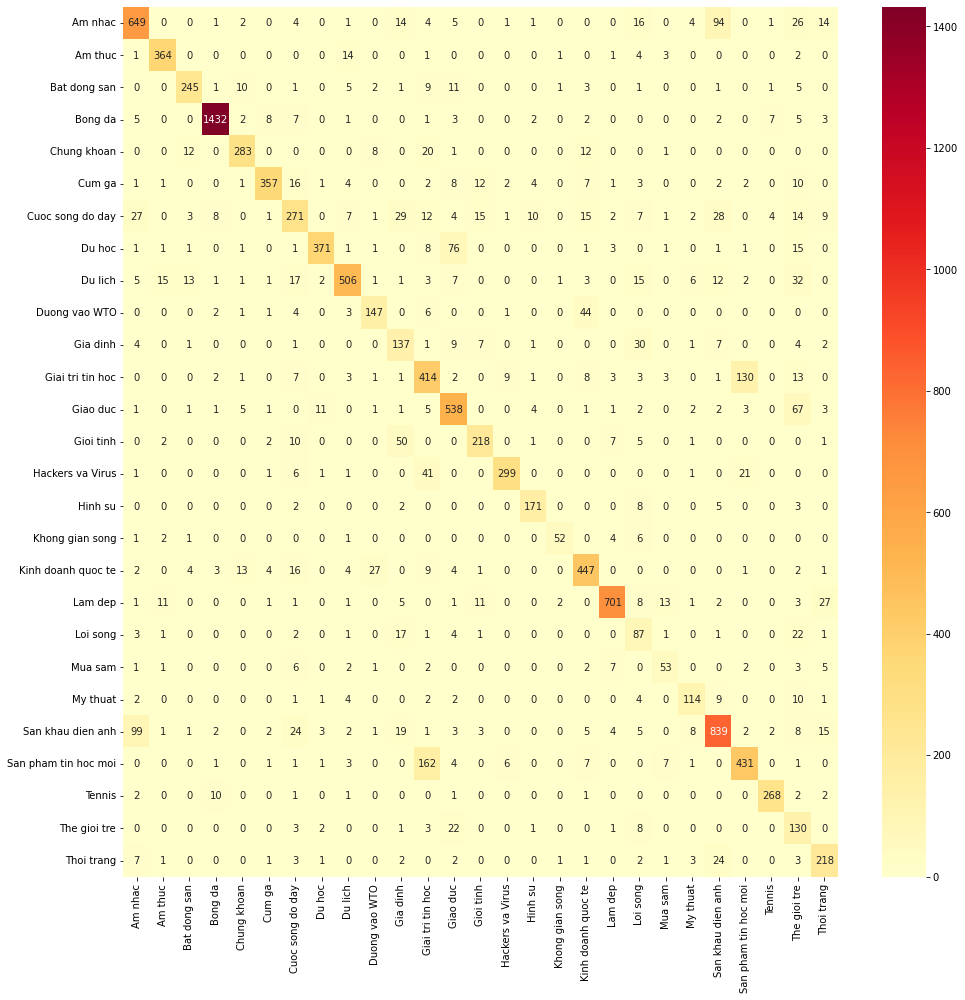

In [ ]:
# visualize bằng heatmap
plt.figure(figsize=(16, 16))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='YlOrRd' , xticklabels=labels, yticklabels=labels)

**Nhận xét:** Mô hình vẫn dự đoán sai những chủ đề tương tự nhau giống như những mô hình sử dụng Machine Learning như 'Sản phẩm tin học', 'Hacker và Virus' và 'Giải trí tin học' hay 'Âm nhạc' và 'Sân khấu điện ảnh'.

###b. Sử dụng SVM để phân loại

In [ ]:
# feed SVM bằng những vector đã được embed
d2v_svm = SVC()

start = time.time()
d2v_svm.fit(embedded_vector, train_y)

print('SVM model finish training after %d seconds' %(time.time() - start))
d2v_svm_path = '/content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/Doc2Vec_SVM.sav'
pickle.dump(d2v_svm, open(d2v_svm_path, 'wb'))

SVM model finish training after 21 seconds


In [ ]:
# Đánh giá độ chính xác của mô hình
# load lại mô hình
model = Doc2Vec.load(doc2vec_path)
d2v_svm = pickle.load(open(d2v_svm_path, 'rb'))
# Chuyển tập test sang dạng vector
test_vector = []
for x in tqdm(test_x):
  test_vector.append(model.infer_vector(x))

  0%|          | 0/12076 [00:00<?, ?it/s]

In [ ]:
# predict
pred_y = d2v_svm.predict(test_vector)

accuracy = np.mean(np.array(pred_y) == np.array(test_y))
print('Doc2Vec-SVM accuracy: ', accuracy)

Doc2Vec-SVM accuracy:  0.7898310698906923


In [ ]:
print(classification_report(test_y, pred_y, zero_division=1))

                      precision    recall  f1-score   support

             Am nhac       0.82      0.84      0.83       813
             Am thuc       0.97      0.84      0.90       400
        Bat dong san       0.92      0.81      0.86       282
             Bong da       0.84      0.99      0.91      1464
         Chung khoan       0.91      0.86      0.89       320
              Cum ga       0.90      0.86      0.88       381
    Cuoc song do day       0.44      0.83      0.57       405
              Du hoc       0.92      0.80      0.86       394
             Du lich       0.76      0.88      0.82       565
       Duong vao WTO       0.78      0.69      0.73       191
            Gia dinh       0.76      0.26      0.39       280
    Giai tri tin hoc       0.57      0.79      0.66       707
            Giao duc       0.70      0.86      0.77       707
           Gioi tinh       0.78      0.72      0.75       268
    Hackers va Virus       0.89      0.74      0.81       319
       

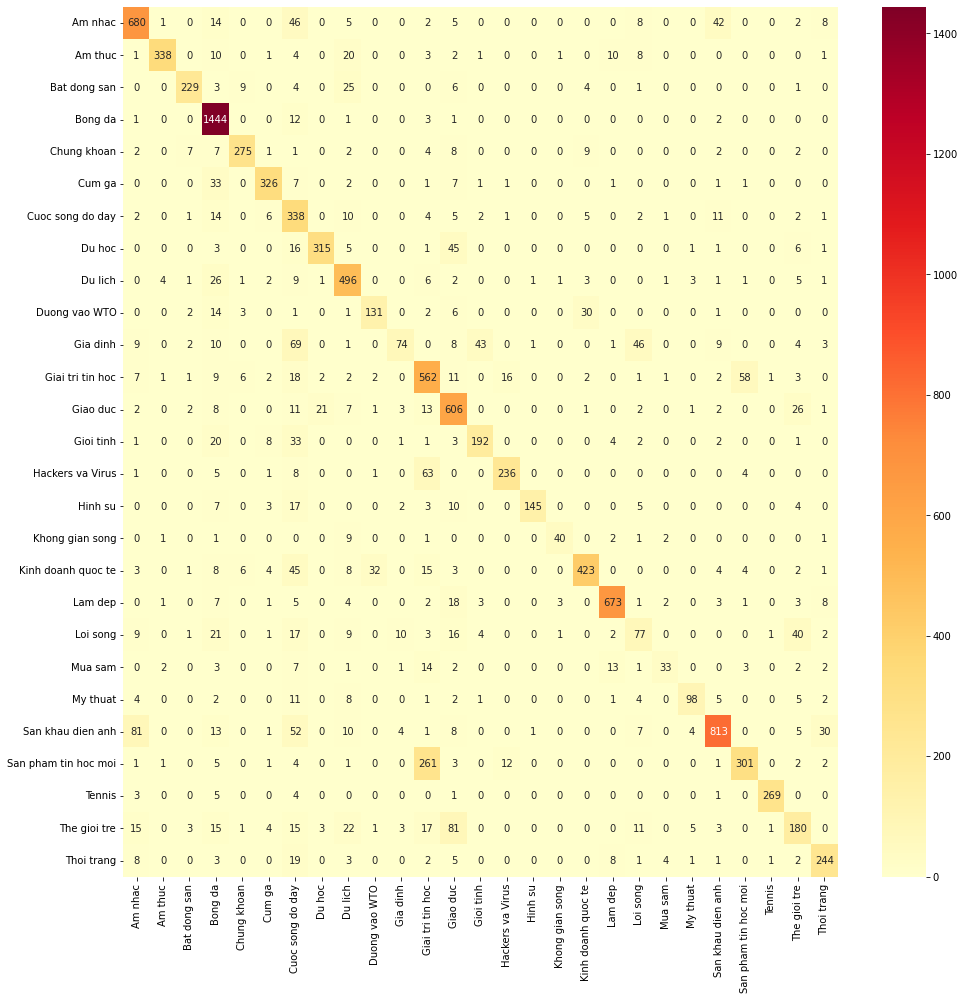

In [ ]:
# visualize bằng heatmap
conf_matrix = confusion_matrix(test_y, pred_y, labels=labels)
plt.figure(figsize=(16, 16))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='YlOrRd' , xticklabels=labels, yticklabels=labels)

**Nhận xét:** Có vẻ việc sử dụng SVM không cho kết quả tốt bằng phương pháp KNN (với k = 10 và khoảng cách được định nghĩa sẵn) trong trường hợp này.

**Thử với Logistic Regression**

In [ ]:
lr = LogisticRegression(max_iter=100_000)
start = time.time()
lr.fit(embedded_vector, train_y)

print('Doc2Vec-LogisticRegression model finish training after %d seconds' %(time.time() - start))

Doc2Vec-LogisticRegression model finish training after 10 seconds


In [ ]:
d2v_lr_path = '/content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/Doc2Vec_LogisticRegression.sav'
pickle.dump(lr, open(d2v_lr_path, 'wb'))

lr = pickle.load(open(d2v_lr_path, 'rb'))

In [ ]:
# predict
pred_y = lr.predict(test_vector)

accuracy = np.mean(np.array(pred_y) == np.array(test_y))
print('Doc2Vec-LogisticRegression accuracy: ', accuracy)

Doc2Vec-LogisticRegression accuracy:  0.8027492547201059


Logistic Regression trong trường hợp này cũng cho kết quả tốt hơn với thời gian train ngắn hơn so với SVM.

#Tổng kết

Với việc trích chọn đặc trưng sử dụng Doc2Vec (một phương pháp sentence embedding) ta có đánh giá sơ bộ các classifier như sau (đã loại bỏ thời gian train feature extracter):

  - Doc2Vec + KNN:
    + Accuracy: 80.67%
    + Training time: 0s
    + Test speed: Khá chậm
  - Doc2Vec + SVM:
    + Accuracy: 78.98%
    + Training time: 21s
    + Test speed: Trung bình
  - Doc2Vec + Logistic Regression:
    + Accuracy: 80.27%
    + Training time: 10s
    + Test speed: Nhanh

Trong trường hợp này, việc sử dụng KNN cho kết quả tốt nhất và không mất thời gian training, tuy nhiên, việc test lại tốn khá nhiều thời gian do cần tính khoảng cách tới các lân cận khác trong lúc test. Vì vậy để đáp ứng những yêu cầu về thời gian thực trong thực tế, việc sử dụng Logistic Regression vẫn là tối ưu hơn. 


Việc train 1 model Doc2Vec để extract feature mất 971s trong khi việc tính TF-IDF chỉ mất 3s. Hơn nữa, kết quả cũng kém hơn việc sử dụng phương pháp Machine Learning truyền thông. Vì vậy, cách làm này sẽ không tối ưu bằng cách trước.


Điều này khá dễ hiểu, bởi vì TF-IDF đánh nặng vào tần suất của những keywords trong văn bản hơn là thứ tự thực hiện của các từ trong văn bản. Điều này rất phù hợp với mục tiêu đề ra là phân loại văn bản, nơi mà trình tự các từ và ngữ cảnh không đóng 1 vai trò quá quan trọng. Trong khi đó, Doc2Vec lại tập trung phần nhiều vào trình tự và ngữ cảnh các từ, điều đó làm cho chủ đề của văn bản có phần mờ nhạt, làm giảm hiệu quả phân loại. Cho nên việc sử dụng Doc2Vec sẽ phù hợp với những bài toán yêu cầu nặng về mặt nội dung và ngữ cảnh mà văn bản đang thể hiện hơn như Text Summarization, Image Captioning, Translation, ...

Một lý do khác đó là việc sử dụng Doc2Vec và classifier khá rời rạc nhau. Doc2Vec chỉ biết phân cụm các văn bản được feed vào như một bài toán unsupervised mà không biết phải phân cụm thế nào cho phù hợp, và việc train model classify lại chỉ đơn thuần tác động nên chính nó. Nói chung, việc train rời rạc 2 phần của mô hình làm nó không có tính kết dính. Để cải thiện điều này, ta phải thực hiện fine-tune lại model Doc2Vec để tăng tính kết dính giữa 2 phần. Tuy nhiên, việc này lại không thể thực hiện ở mô hình này. Hơn nữa, Doc2Vec biểu diễn từ theo 1 chiều làm giảm hiệu suất embedding của mô hình. Vì vậy, ta cần một mô hình mới có thể khắc phục được 2 đặc điểm này của Doc2Vec đó là **biểu diễn 1 chiều** và **không thể fine-tune**.

**Kết luận:** Phần tiếp theo, ta sẽ thử với một mô hình Sequence Embedding khác đang làm mưa làm gió thời gian gần đây. Đó là mô hình BERT. Mô hình này dựa trên kiến trúc Transformer nên có thể biểu diễn từ theo cả 2 chiều, từ đó tăng hiệu quả embedding. Hơn nữa, khác với những mô hình Sentence Embedding trước đó, mô hình BERT có thể fine-tune được. Nhờ vào việc ứng dụng mô hình BERT, nhiều bài toán NLP đã có thể giải được với kết quả SOTA.